# Convolutional Neural Network

This example shows how to design a simple CNN and how to measure the maximum accumulator bit width. 
We further show the impact of strong post-training quantization on accuracy. The maximum accumulator 
bit width that is currently allowed in Concrete-ML is **8** bits.

We simulate the FHE circuit of a CNN with the Virtual Lib, a tool that provides design-time 
information and helps to construct FHE compatible models. Please note that we are not 
compiling the models to FHE in this example, as the accuracy obtained for the FHE-compatible 
configuration is too low. The accuracy of NN models, that have more than a few parameters,
will be improved in future versions of Concrete-ML.

### Import required modules

In [1]:
import numpy as np
import torch
import torch.utils
from concrete.numpy.compilation.configuration import CompilationConfiguration
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn.utils import prune
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the dataset and visualize it

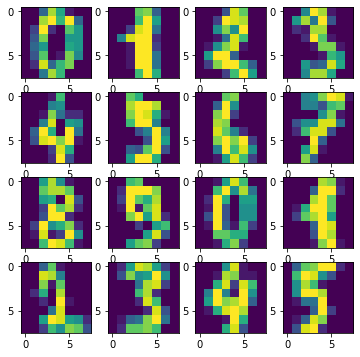

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits dataset, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

Since the accumulator bit width in FHE is small, we prune the convolutional
filters to limit the number of connections per neuron.

Neural network **pruning** is the process by which the synapses of individual neurons in a layer
are forced to have a weight equal to zero. This basically eliminates them from the computation 
and thus they do not increase the accumulator bit width. It has been shown that neural networks can 
maintain their accuracy with a degree of pruning that can 
even exceed 70% for some over-parametrized networks such as VGG16 or large ResNets.

See: https://arxiv.org/pdf/2003.03033.pdf, Figure 8 in Section 7.2, for an evaluation on the 
simple pruning method used in this example.

In [3]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits dataset.

    This class also allows pruning to a maximum of 10 active neurons, which
    should help keep the accumulator bit width low.
    """

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 2, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(2, 3, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(3, 16, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(16, n_classes)

        # Enable pruning, prepared for training
        self.toggle_pruning(True)

    def toggle_pruning(self, enable):
        """Enables or removes pruning."""

        # Maximum number of active neurons (i.e. corresponding weight != 0)
        n_active = 10

        # Go through all the convolution layers
        for layer in (self.conv1, self.conv2, self.conv3):
            s = layer.weight.shape

            # Compute fan-in (number of inputs to a neuron)
            # and fan-out (number of neurons in the layer)
            st = [s[0], np.prod(s[1:])]

            # The number of input neurons (fan-in) is the product of
            # the kernel width x height x inChannels.
            if st[1] > n_active:
                if enable:
                    # This will create a forward hook to create a mask tensor that is multiplied
                    # with the weights during forward. The mask will contain 0s or 1s
                    prune.l1_unstructured(layer, "weight", (st[1] - n_active) * st[0])
                else:
                    # When disabling pruning, the mask is multiplied with the weights
                    # and the result is stored in the weights member
                    prune.remove(layer, "weight")

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.view(-1, 16)
        x = self.fc1(x)
        return x

### Train the CNN

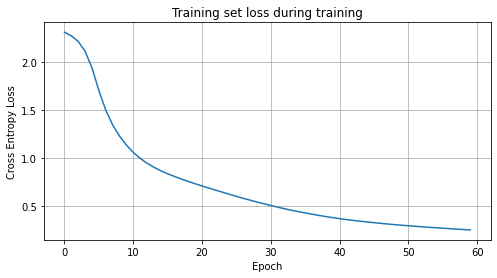

In [4]:
torch.manual_seed(12538040293833290220)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
net = TinyCNN(10)
N_EPOCHS = 60

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
optimizer = torch.optim.Adam(net.parameters())
losses = []
for _ in range(N_EPOCHS):
    losses.append(train_one_epoch(net, optimizer, train_dataloader))

# Finally, disable pruning (sets the pruned weights to 0)
net.toggle_pruning(False)

fig = plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.title("Training set loss during training")
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int32)
    all_targets = np.zeros((len(test_loader)), dtype=np.int32)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(f"Test accuracy: {n_correct / len(test_loader) * 100:.2f}%")


test_torch(net, test_dataloader)

Test accuracy: 90.00%


### Test the network with quantification using the Virtual Lib

Note that this is not a test in FHE. The Virtual Lib only simulates an FHE circuit to give 
insight on the number of accumulator bits that are needed.

In [ ]:
cfg = CompilationConfiguration(
    dump_artifacts_on_unexpected_failures=False,
    enable_unsafe_features=True,  # This is for our tests only, never use that in prod
    # BCM treat_warnings_as_errors=True,
    use_insecure_key_cache=False,
)


def test_with_concrete_virtual_lib(quantized_module, test_loader, use_fhe, use_vl):
    """Test a neural network that is quantized and compiled with Concrete-ML."""

    # When running in FHE, we cast inputs to uint8, but when running using the Virtual Lib (VL)
    # we may want inputs to exceed 8b to test quantization performance. Thus,
    # for VL we cast to int32
    dtype_inputs = np.uint8 if use_fhe else np.int32
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int32)
    all_targets = np.zeros((len(test_loader)), dtype=np.int32)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        # Quantize the inputs and cast to appropriate data type
        x_test_q = quantized_module.quantize_input(data).astype(dtype_inputs)

        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Iterate over single inputs
        for i in range(x_test_q.shape[0]):
            # Inputs must have size (N, C, H, W), we add the batch dimension with N=1
            x_q = np.expand_dims(x_test_q[i, :], 0)

            # Execute either in FHE (compiled or VL) or just in quantized
            if use_fhe or use_vl:
                out_fhe = quantized_module.forward_fhe.encrypt_run_decrypt(x_q)
                output = quantized_module.dequantize_output(out_fhe)
            else:
                output = quantized_module.forward_and_dequant(x_q)

            # Take the predicted class from the outputs and store it
            y_pred = np.argmax(output, 1)
            all_y_pred[idx] = y_pred
            idx += 1

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)
    return n_correct / len(test_loader)


accs = []
accum_bits = []
for n_bits in range(2, 9):
    # Compile and test the network with the Virtual Lib on the whole test set
    q_module_vl = compile_torch_model(
        net,
        x_train,
        n_bits=n_bits,
        use_virtual_lib=True,
        configuration=cfg,
    )
    # pylint: disable=no-member
    # BCM accum_bits.append(q_module_vl.forward_fhe.get_max_bit_width())
    # pylint: enable=no-member

    accs.append(
        test_with_concrete_virtual_lib(
            q_module_vl,
            test_dataloader,
            use_fhe=False,
            use_vl=True,
        )
    )

/Users/benoitchevalliermames/Documents/Zama/Git/concrete-ml-internal/.venv/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:719: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


### Analysis of quantized results

We plot the accuracies obtained for various levels of quantization of weights and activations. 
In addition, we plot the maximum accumulator bit width required to run inference of the network for
each weight and activation bit width. This accumulator bit width is measured by the Virtual Lib and 
can be very useful in designing FHE-compatible neural networks.

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.rcParams["font.size"] = 14
plt.plot(range(2, 9), accs, "-x")
for bits, acc, accum in zip(range(2, 9), accs, accum_bits):
    plt.gca().annotate(str(accum), (bits - 0.1, acc + 0.025))
plt.ylabel("Accuracy on test set")
plt.xlabel("Weight & activation quantization")
plt.grid(True)
plt.title("Accuracy for varying quantization bit width")
plt.show()

### Conclusion

We see that quantization with **2** bit weight and activations is the only viable FHE configuration,
as the accumulator bit width for this configuration is **5-6** bits (can vary due to the final 
distribution of the weights). 

We further see that the number of bits for weigths and activations to achieve an accuracy comparable
to the floating point accuracy is at least **5** bits and requires a **12** bit accumulator.